# Quartz's analysis of organic food prices

For the fuly story we wrote based on this analysis visit Amazon’s [Whole Foods deal isn’t disrupting grocery prices](https://qz.com/1093822)

## Load libraries and dependencies

In [1]:
# load libraries and dependencies
import pandas as pd
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
import numpy as np

## Define the functions used to load, clean, and parse the data

In [2]:
import xml.etree.ElementTree


def get_fruits_and_veg_from_file(fn):
    """load an usda ams xml file and return an array of records"""
    with open(fn) as f:
        xml_str = f.read()
    return parse_xml(xml.etree.ElementTree.fromstring(xml_str))

def parse_xml(xml):
    """take the xml and turn it into a list of dicts"""
    return [parse_xml_item(r) for r in xml]

def parse_xml_item(node):
    """turn a xml node into a dict"""
    node_dict = {n.tag: n.text for n in node}
    node_dict['reportDate'] = datetime.strptime(node_dict['reportDate'], "%m/%d/%Y")
    node_dict['organic'] = parse_organic_res_value(node_dict['organic'])
    node_dict['storeCount'] = int(node_dict['storeCount'].replace(",",""))
    node_dict['avgPrice'] =  parse_price_value(node_dict['avgPrice'])
    node_dict['lowPrice'] =  parse_price_value(node_dict['lowPrice'])
    node_dict['highPrice'] = parse_price_value(node_dict['highPrice'])
    return node_dict

def parse_price_value(p_str):
    """turn a string formatted number into a float"""
    try:
        return np.float64(p_str.replace(",",""))
    except:
        return None

def parse_organic_res_value(org_str):
    """turn a string formatted boolean into a boolean"""
    if org_str == "Y":
        return True
    if org_str == "N":
        return False
    
    # if organic not specified assume it's not organic
    return False

# define a function for aggregating a weighted average of a dataframe

def wmean(group, avg_name, weight_name):
    """
    Take take a grouped dataframe and return a series of the average of the `avg_name` 
    column weighted by the `weight_name` column.
    
    via http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return pd.Series({'wmean_' + avg_name: (d * w).sum() / w.sum()})
    except ZeroDivisionError:
        # if there's no wieght use nominal average
        return pd.Series({'wmean_' + avg_name: d.mean()})
    
def indexed_value(val, base):
    """Take a value and a base and return a 100-based index"""
    return 100 + 100 * (val - base) / base
    

## Load the data

In [3]:
# Load the data
raw = get_fruits_and_veg_from_file("usda_ams_01.xml")
raw_2 = get_fruits_and_veg_from_file("usda_ams_02.xml")
raw.extend(raw_2)

display("The raw data has %s records" % (len(raw),))

# convert the data into a dataframe
allcoms = pd.DataFrame(raw)

## check that the raw data and dataframed data are the same length
assert len(allcoms) == len(raw), "Data not parsed correctly"

display("The dataframe has %s records from %s to %s" % (len(allcoms),allcoms.reportDate.min(), allcoms.reportDate.max()))



'The raw data has 170440 records'

'The dataframe has 170440 records from 2015-10-16 00:00:00 to 2017-10-06 00:00:00'

## Remove the distinction of whether a product was greenhouse grown

In [4]:
index_cols = ["className","commName", "regionName", "variety", "reportDate", "unit", "organic"]

# aggregate all 'environments' into single values
# This combines the prices of greenhouse grown and conventionally grown produce

# create dataframes of the max, min, sum, and weighted avg for each 
# product/region/date/unit/organicness combination
allcoms_gb =  allcoms.groupby(index_cols)
reindexed_allcoms_wmean = pd.DataFrame(allcoms_gb.apply(wmean, "avgPrice","storeCount"))
reindexed_columns_sum = allcoms_gb.sum()
reindexed_columns_min = allcoms_gb.min()
reindexed_columns_max = allcoms_gb.max()

# combine the above into a single dataframe
reindexed_allcoms = reindexed_columns_sum.join(reindexed_allcoms_wmean)[["wmean_avgPrice", "storeCount"]]
reindexed_allcoms = reindexed_allcoms.join(reindexed_columns_min[["lowPrice"]])
reindexed_allcoms = reindexed_allcoms.join(reindexed_columns_max[["highPrice"]])

# clean up the column names
reindexed_allcoms.columns = ["avgPrice", "storeCount", "lowPrice", "highPrice"]

reindexed_allcoms.head()

avgPrice  \
className commName    regionName variety reportDate unit organic             
FRUITS    APPLE PEARS ALASKA             2015-12-11 each False        1.38   
                                         2016-01-08 each False        1.49   
                                         2016-01-15 each False        1.49   
                                         2016-02-05 each False        2.28   
                                         2016-02-12 each False        1.00   

                                                                  storeCount  \
className commName    regionName variety reportDate unit organic               
FRUITS    APPLE PEARS ALASKA             2015-12-11 each False            14   
                                         2016-01-08 each False            11   
                                         2016-01-15 each False            11   
                                         2016-02-05 each False            27   
                                         2016-02-12 each False             3   

                                                                  lowPrice  \
className commName    regionName variety reportDate unit organic             
FRUITS    APPLE PEARS ALASKA             2015-12-11 each False        0.98   
                                         2016-01-08 each False        1.49   
                                         2016-01-15 each False        1.49   
                                         2016-02-05 each False        2.28   
                                         2016-02-12 each False        1.00   

                                                                  highPrice  
className commName    regionName variety reportDate unit organic             
FRUITS    APPLE PEARS ALASKA             2015-12-11 each False         1.49  
                                         2016-01-08 each False         1.49  
                                         2016-01-15 each False         1.49  
                                         2016-02-05 each False         2.28  
                                         2016-02-12 each False         1.00

## Reshape the data

This makes comparing organic and conventionally grown prices easier to compare by putting them on the same row

In [5]:
# reshape the data into a form where it's easier to compare organic and conventionally grown

relvant_cols = ["avgPrice", "lowPrice", "highPrice", "storeCount"]

# create two data frames, one for organic and one for not organic then join them

# create the organic one
reindexed_allcoms_organic = reindexed_allcoms[
    reindexed_allcoms.index.get_level_values('organic') == True
][relvant_cols]

reindexed_allcoms_organic.columns = map(lambda x: x + "_organic", reindexed_allcoms_organic.columns)

# create the not organic one
reindexed_allcoms_notorganic = reindexed_allcoms[
    reindexed_allcoms.index.get_level_values('organic') == False
][relvant_cols]

# now join them
allcoms_rejoined = reindexed_allcoms_organic.reset_index("organic", drop=True).join(reindexed_allcoms_notorganic.reset_index("organic", drop=True))

# on the joined dataframe calcuclate the organic premium / discount on a dollar and percent basis
allcoms_rejoined["spread"] = allcoms_rejoined["avgPrice_organic"] - allcoms_rejoined["avgPrice"]
allcoms_rejoined["pct_markupdown"] = allcoms_rejoined.spread / allcoms_rejoined.avgPrice * 100

allcoms_rejoined.head()


avgPrice_organic  \
className commName    regionName variety reportDate unit                          
FRUITS    APPLE PEARS ALASKA             2016-11-18 each                   1.25   
                      NATIONAL           2015-10-23 per pound              2.89   
                                         2015-10-30 per pound              2.89   
                                         2016-10-28 each                   2.50   
                                         2016-11-18 each                   1.25   

                                                               lowPrice_organic  \
className commName    regionName variety reportDate unit                          
FRUITS    APPLE PEARS ALASKA             2016-11-18 each                   1.25   
                      NATIONAL           2015-10-23 per pound               NaN   
                                         2015-10-30 per pound               NaN   
                                         2016-10-28 each                    NaN   
                                         2016-11-18 each                    NaN   

                                                               highPrice_organic  \
className commName    regionName variety reportDate unit                           
FRUITS    APPLE PEARS ALASKA             2016-11-18 each                    1.25   
                      NATIONAL           2015-10-23 per pound                NaN   
                                         2015-10-30 per pound                NaN   
                                         2016-10-28 each                     NaN   
                                         2016-11-18 each                     NaN   

                                                               storeCount_organic  \
className commName    regionName variety reportDate unit                            
FRUITS    APPLE PEARS ALASKA             2016-11-18 each                        3   
                      NATIONAL           2015-10-23 per pound                  18   
                                         2015-10-30 per pound                  36   
                                         2016-10-28 each                        5   
                                         2016-11-18 each                        3   

                                                               avgPrice  \
className commName    regionName variety reportDate unit                  
FRUITS    APPLE PEARS ALASKA             2016-11-18 each            NaN   
                      NATIONAL           2015-10-23 per pound       1.9   
                                         2015-10-30 per pound       1.8   
                                         2016-10-28 each            1.0   
                                         2016-11-18 each            1.0   

                                                               lowPrice  \
className commName    regionName variety reportDate unit                  
FRUITS    APPLE PEARS ALASKA             2016-11-18 each            NaN   
                      NATIONAL           2015-10-23 per pound       NaN   
                                         2015-10-30 per pound       NaN   
                                         2016-10-28 each            NaN   
                                         2016-11-18 each            NaN   

                                                               highPrice  \
className commName    regionName variety reportDate unit                   
FRUITS    APPLE PEARS ALASKA             2016-11-18 each             NaN   
                      NATIONAL           2015-10-23 per pound        NaN   
                                         2015-10-30 per pound        NaN   
                                         2016-10-28 each             NaN   
                                         2016-11-18 each             NaN   

                                                               storeCount  \
className commName    regionName variety reportDate 

## Create an index of nation-wide advertised produce prices

As noted in the [story](https://qz.com/1093822):

> To assess price trends we created an index that combines the relative price of every advertised piece of produce logged by the USDA. The index sets 100 to the lowest price a product has been listed for in the 52 weeks months ending Oct. 6. Each product's index is then combined using a weighted average based on the number of stores it is being advertised by. It allows an easy comparison of prices across time frames as products go in and out of season and get stocked by more and fewer stores.

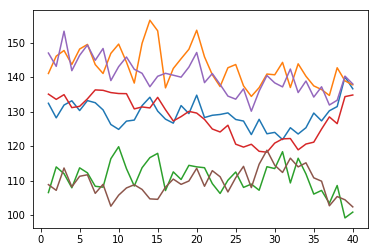

In [6]:
# Make an index of all advertized produce prices

splityear = datetime(2017,1,1)
one_year = timedelta(days=52*7)

# start with all the records and turn the index into factors
rejoined_comms_date_as_factor = allcoms_rejoined.reset_index()

# create a dataframe to store the low price of the past 52 weeks 
lowest_ad_price = allcoms_rejoined.reset_index("reportDate")

# store the date of a one year prior to the most recent data
year_ago = lowest_ad_price.reportDate.max() - one_year

# limit the data to the prior year, then reset the index to create a grouped dataframe which can be minned
lowest_ad_price = lowest_ad_price[lowest_ad_price.reportDate >= year_ago].reset_index().groupby(lowest_ad_price.index.names).min()
lowest_ad_price = lowest_ad_price[["avgPrice", "avgPrice_organic"]]

# join the lowest price figure to every record of that product
with_indexed = allcoms_rejoined.reset_index("reportDate")
with_indexed = with_indexed.join(lowest_ad_price, lsuffix="", rsuffix="_index_ref", how="left").reset_index()

# limit to only National 

with_indexed = with_indexed[with_indexed.regionName == "NATIONAL"]

# Caclulate the indexed price for every product
with_indexed.loc[:,"avgPrice_indexed"] = indexed_value(with_indexed.avgPrice, with_indexed.avgPrice_index_ref)
with_indexed.loc[:,"avgPrice_organic_indexed"] = indexed_value(with_indexed.avgPrice_organic, with_indexed.avgPrice_organic_index_ref)

# Reduce the individual indexed values by grouping by date and taking 
# an average weighted by number of advertising stores
means_reg = with_indexed.groupby("reportDate").apply(wmean, "avgPrice_indexed", "storeCount")
means_org = with_indexed.groupby("reportDate").apply(wmean, "avgPrice_organic_indexed", "storeCount_organic")

#
# This is a very quick and dirty way to use a simple
# mean rather than a weighted one. If you're curious
# about how that would change things uncomment the below
#
# means_reg = with_indexed.groupby("reportDate").mean()
# means_org = with_indexed.groupby("reportDate").mean()

# means_reg.columns = list(map(lambda x: "wmean_" + x, means_reg))
# means_reg = means_reg[["wmean_avgPrice_indexed"]]

# means_org.columns = list(map(lambda x: "wmean_" + x, means_org))
# means_org = means_org[["wmean_avgPrice_organic_indexed"]]


# Rejoin the organic and conventional weighted averages
wavg = means_reg.join(means_org).reset_index()

# calculate the spread between the organic level and conventional level
wavg.loc[:,"spread"] = wavg.wmean_avgPrice_organic_indexed - wavg.wmean_avgPrice_indexed
wavg.loc[:,"markup"] = (wavg.spread / wavg.wmean_avgPrice_indexed) * 100 + 100

# Add the week number for easier charting
wavg.loc[:,"weekNum"] = wavg.reportDate.dt.strftime("%U")

# split the data into this year and last year
wavg2017 = wavg[wavg.reportDate >= splityear]
wavg2016 = wavg[
    (wavg.reportDate < splityear) &
    (wavg.reportDate >= splityear - one_year)
]

# limit the data to the weeks where the data overlaps
wavg2017 = wavg2017[wavg2017.weekNum >= wavg2016.weekNum.min()]
wavg2016 = wavg2016[wavg2016.weekNum <= wavg2017.weekNum.max()]

# Plot 2017 figures as lines
plt.plot(wavg2017.weekNum, wavg2017.wmean_avgPrice_indexed)
plt.plot(wavg2017.weekNum, wavg2017.wmean_avgPrice_organic_indexed)
plt.plot(wavg2017.weekNum, wavg2017.markup)

# Plot the 2016 figures as lines
plt.plot(wavg2016.weekNum, wavg2016.wmean_avgPrice_indexed)
plt.plot(wavg2016.weekNum, wavg2016.wmean_avgPrice_organic_indexed)
plt.plot(wavg2016.weekNum, wavg2016.markup)

#
# Plot the spread (will scale hard to read)
#

# plt.plot(wavg2017.weekNum, wavg2017.spread)
# plt.plot(wavg2016.weekNum, wavg2016.spread)


plt.show()

In [7]:
# This cell left intentionally blank

## Now lets look at individual products
### On average, how many stores are advertising a product on any given week?

In [8]:
# what are the most widely advertised products nationally

# drop the date index, class index, and turn the region into a factor
no_dates_all = allcoms_rejoined.reset_index(["reportDate", "className"], drop=True).reset_index("regionName")

# only use national figures
no_dates = no_dates_all[no_dates_all.regionName == "NATIONAL"]

# determine the average number of store advertisements per week (in weeks where its advertised)
products_by_store_count = no_dates.groupby(no_dates.index.names).mean()[["storeCount_organic", "storeCount"]].sort_values("storeCount_organic", ascending=False)

display(HTML("<h4>Average Weekly Store Counts</h4>"))
products_by_store_count.head(20)

storeCount_organic  \
commName             variety                        unit                                     
SALAD                MIXED TYPES                    5 - 9 oz package           3429.686275   
STRAWBERRIES                                        1 lb package               2800.011236   
GRAPES               RED SEEDLESS                   per pound                  2619.223881   
                     WHITE SEEDLESS TYPE            per pound                  2607.016129   
CARROTS              BABY PEELED                    1 lb bag                   2249.705882   
TOMATOES, GRAPE TYPE                                1 pint package             2008.588235   
PEACHES              VARIOUS YELLOW FLESH VARIETIES per pound                  1571.208333   
LETTUCE, ROMAINE     HEARTS                         3 count package            1562.068627   
BANANAS                                             per pound                  1465.980392   
NECTARINES           VARIOUS YELLOW FLESH VARIETIES per pound                  1364.051282   
BLUEBERRIES                                         6 oz package               1358.931034   
APPLES               GALA                           per pound                  1353.969388   
BLACKBERRIES                                        5.6 - 6 oz package         1119.292929   
SALAD                MIXED TYPES                    1 lb bag                   1070.207921   
KALE GREENS                                         per bunch                  1069.215686   
APPLES               FUJI                           per pound                  1004.402174   
TOMATOES             VINE RIPES, ON THE VINE        per pound                   992.107843   
AVOCADOS             HASS                           each                        937.485149   
APPLES               HONEYCRISP                     per pound                   918.904762   
CHERRIES             RED VARIETIES                  per pound                   908.181818   

                                                                          storeCount  
commName             variety                        unit                              
SALAD                MIXED TYPES                    5 - 9 oz package     5922.019608  
STRAWBERRIES                                        1 lb package         8937.000000  
GRAPES               RED SEEDLESS                   per pound           11120.955224  
                     WHITE SEEDLESS TYPE            per pound            8810.516129  
CARROTS              BABY PEELED                    1 lb bag             4473.784314  
TOMATOES, GRAPE TYPE                                1 pint package       2396.088235  
PEACHES              VARIOUS YELLOW FLESH VARIETIES per pound           11408.083333  
LETTUCE, ROMAINE     HEARTS                         3 count package      1636.019608  
BANANAS                                             per pound            1906.970588  
NECTARINES           VARIOUS YELLOW FLESH VARIETIES per pound            9043.769231  
BLUEBERRIES                                         6 oz package         2552.436782  
APPLES               GALA                           per pound            3887.693878  
BLACKBERRIES                                        5.6 - 6 oz package   5403.595960  
SALAD                MIXED TYPES                    1 lb bag              714.721649  
KALE GREENS                                         per bunch             633.921569  
APPLES               FUJI                           per pound            2337.391304  
TOMATOES             VINE RIPES, ON THE VINE        per pound            5619.813725  
AVOCADOS             HASS                           each                 6432.643564  
APPLES               HONEYCRISP                     per pound            5160.952381  
CHERRIES             RED VARIETIES                  per pound           11386.863636

### How many weeks has each product shown up in advertisments?

In [9]:
# What are the most consistently advertised organic products nationally

# drop the class index and make region and date factors
for_count_all = allcoms_rejoined.reset_index(["className"], drop=True).reset_index(["regionName", "reportDate"])

# only use national figures
for_count = for_count_all[for_count_all.regionName == "NATIONAL"]

# determine the number of weeks a product has been advertised in the dataset by counting the unique dates per product
products_by_ad_count = for_count.groupby(for_count.index.names).count()[["reportDate"]].sort_values("reportDate", ascending=False)

display(HTML("<h4>Total week counts</h4>"))
products_by_ad_count.head(20)

reportDate
commName             variety                 unit                          
TOMATOES             VINE RIPES, ON THE VINE per pound                  102
TOMATOES, GRAPE TYPE                         1 pint package             102
SALAD                MIXED TYPES             10 - 12 oz package         102
MUSHROOMS            WHITE                   8 oz package               102
BANANAS                                      per pound                  102
LETTUCE, ROMAINE     HEARTS                  3 count package            102
LETTUCE, GREEN LEAF                          each                       102
SALAD                MIXED TYPES             5 - 9 oz package           102
CELERY                                       each                       102
KALE GREENS                                  per bunch                  102
CARROTS              BABY PEELED             1 lb bag                   102
TOMATOES, GRAPE TYPE                         10 oz package              101
SALAD                MIXED TYPES             1 lb bag                   101
LETTUCE, RED LEAF                            each                       101
AVOCADOS             HASS                    each                       101
CELERY               HEARTS                  each                       101
BEETS                                        per bunch                  101
ONIONS DRY           YELLOW                  3 lb bag                   101
APPLES, PROCESSED    JUICE                   64 oz (1/2 gallon)         101
POTATOES             RUSSET                  5 lb bag                   101

### Which products are both advertised by lots of stores and show up in advertisments a lot?

In [10]:

# products that are above median for how many stores advertise them
manystores_advert_organic_products = products_by_store_count[
    products_by_store_count.storeCount_organic >= products_by_store_count.storeCount_organic.median()
]

# products that are above median for how often they're advertised
commonly_advert_organic_products = products_by_ad_count[
    products_by_ad_count.reportDate >= products_by_ad_count.reportDate.median()
]

# the intersection of the two
manystores_and_commonly = commonly_advert_organic_products.join(manystores_advert_organic_products, how='inner')

# reset the index of the intersection dataframe to sort then reset it back
meet_both_criteria = manystores_and_commonly.reset_index().sort_values("commName").set_index(manystores_and_commonly.index.names)

display(HTML("<h4>How many products are both widely advertised and consistently advertised?</h4>"))

print("%s of %s product measure pairs" % (len(meet_both_criteria), len(products_by_store_count)))

103 of 255 product measure pairs


In [11]:
# this cell left intentionally blank

## Lets chart each product by region to see if there are any trends

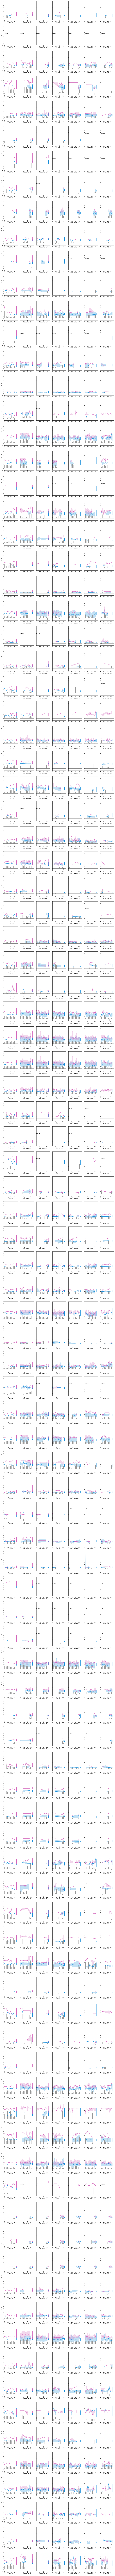

In [12]:
# How have prices changed for the both widely advertised and consistently advertised products

# these are the regions to chart, Alaska and Hawaii are removed
unique_regions = [
    'NATIONAL', 
    'NORTHEAST U.S.', 
    'SOUTHEAST U.S.', 
    'MIDWEST U.S.', 
    'SOUTH CENTRAL U.S.', 
    'SOUTHWEST U.S.', 
    'NORTHWEST U.S.'
]

# take all the records and make regions and dates factors and drop class
reduced_allcoms = allcoms_rejoined.reset_index(["regionName", "reportDate"]).reset_index("className", drop=True)

# limit the chartable data to items that are widely advert and consistently advert
# then turn index items into factors. This is done by joining the data above with
# just the index of the meet_both_criteria dataframe—thus the `[[]]` notation
all_for_plot = meet_both_criteria[[]].join(reduced_allcoms, how="left").reset_index()

# create a unique per product id 
all_for_plot["product_id"] = all_for_plot.commName + ' ' + all_for_plot.variety + ' ' + all_for_plot.unit

# store a list of the unique products
unique_products = list(all_for_plot.product_id.unique())

# create a locator and formatter for date charting
months = mdates.MonthLocator(interval=1)
month_formatter = mdates.DateFormatter('%b')

# create a matplot lib figure and axes to iterate over and chart into
# the size of the figure is adjusted for how many products are inputted
fig, axes = plt.subplots(len(meet_both_criteria),len(unique_regions), sharey='row', figsize=(20, len(unique_products)/43*200))

# tighten the space between charts
fig.subplots_adjust(hspace=0.3)

# the date the Amazon/Whole Foods deal closed
close_date = datetime(2017,8,28)

# the date to start the plot from
start_date = datetime(2017, 6, 29)

# the date to end the plot on
end_date = datetime.now()

# The date 52 weeks prior to the end date
year_ago = end_date - timedelta(days=52*7)

# create a dataframe for the prior year data
for_prior_year = all_for_plot[all_for_plot.reportDate.between(year_ago,end_date,inclusive=True)]

# create a dataframe for the current year data
for_plot = all_for_plot[all_for_plot.reportDate.between(start_date,end_date, inclusive=True)]

# create a chart for every product (i loop) and every region (j loop)
for i in range(len(unique_products)):
    # current product
    prod = unique_products[i]
    for j in range(len(unique_regions)):
        # current region
        region = unique_regions[j]
        
        #current axes
        ax = axes[i][j]
        
        # filter the data to the current product and region
        to_plot = for_plot[
            (for_plot.product_id == prod) &
            (for_plot.regionName == region)
        ].set_index("reportDate")
        
        # copy the date index
        date_index = to_plot.index.to_pydatetime()
        
        # filter the prior year data to the current product and region
        prior_year = for_prior_year[
            (for_prior_year.product_id == prod) &
            (for_prior_year.regionName == region)
        ]
        
         
        # label yaxis of the first chart in a row with the product
        if j  == 0:
            ax.set_ylabel(prod)
        
        # label the xaxis with the region
        ax.set_xlabel(region)
        
        # set the axes scales
        # use a constant scale from chart to chart
        ax.set_ylim([-1,8])
        ax.set_xlim([start_date, end_date + timedelta(days=9)])
        ax.xaxis.set_major_locator( months )
        ax.xaxis.set_major_formatter(month_formatter)
        
        # if no products were advertized in a region
        # during the period, label it
        if len(date_index) == 0:
            ax.text(start_date, 4.5, "No Data")
            continue
        
        # Plot conventionally grown items
        
        # plot the average price as dots and a line
        ax.scatter(date_index, to_plot.avgPrice, color="#168dd9", s=3)
        ax.plot(date_index, to_plot.avgPrice, color="#168dd9")
        
        # plot an area between the low and high prices
        ax.fill_between(date_index, to_plot.lowPrice, to_plot.highPrice, alpha=0.25, color="#168dd9")
        
        # plot the 52 week range of average price price movements
        ax.axhspan(
            xmin=0.9,
            xmax=0.91,
            ymin=prior_year.avgPrice.max(), 
            ymax=prior_year.avgPrice.min(), 
            color="#168dd9",
            linewidth=2
        )

        
        # Now do the same for organic
        ax.scatter(date_index, to_plot.avgPrice_organic, color="#d365ba", s=3)
        ax.plot(date_index, to_plot.avgPrice_organic, color="#d365ba")
        ax.fill_between(date_index, to_plot.lowPrice_organic, to_plot.highPrice_organic, alpha=0.25, color="#d365ba")
        ax.axhspan(
            xmin=0.91,
            xmax=0.92,
            ymin=prior_year.avgPrice_organic.max(), 
            ymax=prior_year.avgPrice_organic.min(), 
            color="#d365ba"
        )
        
        # Plot the spread between organic and conventional as a spread
        ax.bar(date_index, to_plot.spread, width=4, color="#969696")
        
        # add a zero baseline
        ax.axhline(color="#000000", linewidth=0.5)
        
        # add a vertical line on the Amazon/Whole Foods close date
        ax.axvline(close_date, color="#000000", linewidth=0.5)
        
        